In [ ]:


class NinaDataParser:

    raw_data_dir    = "raw"
    proc_data_dir   = "processed"
    nina_data_urls  = {
                        "s1.zip": "https://zenodo.org/record/1000116/files/s1.zip?download=1",
                        "s2.zip": "https://zenodo.org/record/1000116/files/s2.zip?download=1",
                        "s3.zip": "https://zenodo.org/record/1000116/files/s3.zip?download=1",
                        "s4.zip": "https://zenodo.org/record/1000116/files/s4.zip?download=1",
                        "s5.zip": "https://zenodo.org/record/1000116/files/s5.zip?download=1",
                        "s6.zip": "https://zenodo.org/record/1000116/files/s6.zip?download=1",
                        "s7.zip": "https://zenodo.org/record/1000116/files/s7.zip?download=1",
                        "s8.zip": "https://zenodo.org/record/1000116/files/s8.zip?download=1",
                        "s9.zip": "https://zenodo.org/record/1000116/files/s9.zip?download=1",
                        "s10.zip": "https://zenodo.org/record/1000116/files/s10.zip?download=1"
                    }

    loaded_data = {}    # A dictionary with the following structure:
                        #
                        #       {
                        #           "s1": {
                        #                       "E1": {... },
                        #                       "E2": {... },
                        #                       "E3": {... }
                        #                   }
                        #
                        #           "s2:" {
                        #                       "E1": {... }, ...
                        #                   }
                        #
                        #           ...
                        #       }


    def __init__(self, all_data_path, grab_all_data = True):

        if all_data_path is None:
            raise ValueError("All data path is empty.")

        #
        # Create directory structure
        #
        if not os.path.exists(all_data_path):
            os.makedirs(all_data_path)

        self.raw_data_path   = os.path.join(all_data_path, self.raw_data_dir)
        self.proc_data_path  = os.path.join(all_data_path, self.proc_data_dir)

        if not os.path.exists(self.raw_data_path):
            os.makedirs(self.raw_data_path)
        if not os.path.exists(self.proc_data_path):
            os.makedirs(self.proc_data_path)

        #
        # Obtain Nina dataset
        #
        if grab_all_data:
            if self.miss_proc_data():
                if self.miss_raw_data():
                    self.get_raw_data()
                self.process_raw_data()


    def load_processed_data(self):

        if self.miss_proc_data():
            raise RuntimeError("Missing processed data, unable to load processed data.")

        for subdir, dirs, files in os.walk(self.proc_data_path):
            for file in files:
                if file.endswith('.mat'):
                    file_path = os.path.join(subdir, file)

                    patient = subdir.split('/')[-1]
                    if patient not in self.loaded_data:
                        self.loaded_data[patient] = {}

                    _, exercise, _ = file.split('.')[0].split('_')
                    self.loaded_data[patient][exercise] = sio.loadmat(file_path)

        return self.loaded_data


    def get_raw_data(self):
        """
            Downloads each missing zip file into the "raw" directory.
        """

        zip_files   = list(self.nina_data_urls.keys())

        for i, zip in enumerate(zip_files):
            cur_path = os.path.join(self.raw_data_path, zip)

            if not os.path.exists(cur_path):
                cur_url         = self.nina_data_urls[zip]
                http_request    = urllib.request.urlopen(cur_url)

                if http_request is None:
                    raise RuntimeError("Unable to open the following url \n{}".format(cur_url))
                else:
                    print("{}/{}. Downloading \"{}\".".format(i + 1, len(zip_files), cur_url))

                with open(cur_path, "wb") as f:
                    f.write(http_request.read())


    def process_raw_data(self):
        """
            Extracts each zip file into the "processed" directory.
        """

        for zip in self.nina_data_urls.keys():

            cur_proc_path   = os.path.join(self.proc_data_path, zip.replace(".zip", ""))

            if not os.path.exists(cur_proc_path):
                cur_zip_path    = os.path.join(self.raw_data_path, zip)
                zip_ref         = zipfile.ZipFile(cur_zip_path, 'r')

                zip_ref.extractall(self.proc_data_path)
                zip_ref.close()

    def miss_proc_data(self):
        proc_data_miss = False

        for zip in self.nina_data_urls.keys():
            cur_proc_path = os.path.join(self.proc_data_path, zip.replace(".zip", ""))
            if not os.path.exists(cur_proc_path):
                proc_data_miss = True

        return proc_data_miss

    def miss_raw_data(self):
        raw_data_miss = False

        for zip in self.nina_data_urls.keys():
            cur_path = os.path.join(self.raw_data_path, zip)
            if not os.path.exists(cur_path):
                raw_data_miss = True

        return raw_data_miss

In [ ]:
import os
from six.moves import urllib
import scipy.io as sio
import zipfile
import numpy as np
from abc import ABC, abstractmethod
import copy
from tqdm import tqdm


DATA_PATH = "all_data/"
MODEL_PATH = "all_models/"


In [ ]:
data_parser = NinaDataParser(DATA_PATH)

1/10. Downloading "https://zenodo.org/record/1000116/files/s1.zip?download=1".
2/10. Downloading "https://zenodo.org/record/1000116/files/s2.zip?download=1".
3/10. Downloading "https://zenodo.org/record/1000116/files/s3.zip?download=1".
4/10. Downloading "https://zenodo.org/record/1000116/files/s4.zip?download=1".
5/10. Downloading "https://zenodo.org/record/1000116/files/s5.zip?download=1".
6/10. Downloading "https://zenodo.org/record/1000116/files/s6.zip?download=1".
7/10. Downloading "https://zenodo.org/record/1000116/files/s7.zip?download=1".
8/10. Downloading "https://zenodo.org/record/1000116/files/s8.zip?download=1".
9/10. Downloading "https://zenodo.org/record/1000116/files/s9.zip?download=1".
10/10. Downloading "https://zenodo.org/record/1000116/files/s10.zip?download=1".


In [ ]:
loaded_nina = data_parser.load_processed_data()

In [ ]:

class FeatureExtractor(ABC):
    """
        Transforms raw EMG/IMU samples into a feature vector used for classification
    """

    requires_global_setup   = False

    @abstractmethod
    def extract_feature_point(self, raw_samples):
        """
        :param raw_samples: A window of emg samples.
        :return: A single feature point.
        """
        pass

    @abstractmethod
    def global_setup(self, all_raw_samples):
        """
              :param all_raw_samples: All windows of emg samples.
        """
        pass

In [ ]:
from pywt import wavedec

class MarginalDiscreteWaveletTransform(FeatureExtractor):
    """
        Refer to:
            'Lucas M, Gaufriau A, Pascual S, Doncarli C, Farina D. Multi-channel surface EMG classification using
                support vector machines and signal-based wavelet optimization. Biomedical Signal Processing and
                Control. 2008; 3(2):169–174. https://doi.org/10.1016/j.bspc.2007.09.002'

        Compute a discrete wavelet transform, and sums over each level of the transform (rectified)
    """

    num_levels      = 3
    mother_wavelet  = "db7"

    def extract_feature_point(self, raw_samples):

        num_channels    = raw_samples.shape[1]
        all_coeff       = []

        for i in range(num_channels):
            coeffs = wavedec(raw_samples[:, i], self.mother_wavelet, level=self.num_levels)

            # "Marginal" of each level
            for j in range(self.num_levels):
                all_coeff.append(np.sum(np.abs(coeffs[j])))

        all_coeff   = np.array(all_coeff)
        return all_coeff

    def global_setup(self, all_raw_samples):
        pass

In [ ]:
feat_ext = MarginalDiscreteWaveletTransform()


In [ ]:
class Dataset(ABC):

    window_size     = 200
    overlap_size    = 100
    num_classes     = 52 + 1
    balance_classes = True # Will limit number of rest samples for train/test

    # Filled via "create_dataset()"
    train_features  = None
    train_labels    = None
    test_features   = None
    test_labels     = None
    all_samples     = None

    # Need to correct labels, by inspecting exercise number
    E1_classes      = 12
    E2_classes      = 17
    E3_classes      = 23
    E3_name         = "E3"
    E2_name         = "E2"
    rest_label      = 0

    # Data augmentation parameters
    snr_max     = 50 # Signal-to-Noise ratio = (variance of signal) / (variance of noise)
    snr_min     = 25
    snr_ticks   = 3 # Number of increments

    def __init__(self, all_data_path, feature_extractor, augment_data = True):

        if feature_extractor is None:
            raise ValueError("Feature extractor is empty.")
        if all_data_path is None:
            raise ValueError("All data path is empty.")

        self.feature_extractor  = feature_extractor
        self.all_data_path      = all_data_path
        self.augment_data       = augment_data

    def create_dataset(self, loaded_data, adjust_labels = True):

        if self.feature_extractor.requires_global_setup:
            self.create_dataset_helper(loaded_data, True, adjust_labels)

        self.create_dataset_helper(loaded_data, False, adjust_labels)

    def create_dataset_helper(self, loaded_data, obtain_all_samples, adjust_labels):
        """
            Converts loaded data (via NinaDataParser) into a useable, baseline dataset, consisting of:
                1. train_features
                2. train_labels
                3. test_features
                4. test_labels

        :param feature_extractor: A function that transform 40 emg samples (a window) into a single feature point.
        :param obtain_all_samples: Avoid creating a train/test split, simply obtain all samples of windowed data.
        :param adjust_labels: Adjust the ground truth labels (according to exercise number)
        """

        if self.load_dataset():
            return

        # To be filled
        self.train_features = []
        self.train_labels   = []
        self.test_features  = []
        self.test_labels    = []
        self.all_samples    = []

        # Class balancing
        num_samples         = 0
        num_rest_samples    = 0

        for patient in tqdm(loaded_data.keys()):
            for ex in loaded_data[patient].keys():
                self.process_single_exercise(loaded_data, patient, ex, num_samples,
                                                num_rest_samples, obtain_all_samples, adjust_labels)

        # Convert to numpy arrays:
        #
        if obtain_all_samples:
            #self.all_samples    = np.array(self.all_samples)
            self.feature_extractor.global_setup(self.all_samples)
        else:
            if self.augment_data:
                self.create_augmented_data(loaded_data, adjust_labels)

            self.train_features = np.array(self.train_features)
            self.train_labels   = np.array(self.train_labels)
            self.test_features  = np.array(self.test_features)
            self.test_labels    = np.array(self.test_labels)

            # Save the above to the baseline dataset directory:
            self.save_dataset()

    def save_dataset(self):

        feat_ext_name   = self.feature_extractor.__class__.__name__
        feat_path       = os.path.join(self.all_data_path, self.get_dataset_name(), feat_ext_name)

        if not os.path.exists(feat_path):
            os.makedirs(feat_path)

        if self.train_features is not None:
            np.save(os.path.join(feat_path, "train_features"), self.train_features)
        if self.train_labels is not None:
            np.save(os.path.join(feat_path, "train_labels"), self.train_labels)
        if self.test_features is not None:
            np.save(os.path.join(feat_path, "test_features"), self.test_features)
        if self.test_labels is not None:
            np.save(os.path.join(feat_path, "test_labels"), self.test_labels)

        if ((self.train_labels is None) or (self.train_labels is None) or
            (self.test_features is None) or (self.test_labels is None)):
            raise RuntimeError("One of the dataset pieces are empty.")

    def load_dataset(self):
        """
        :return: True, if this function was able to load the baseline dataset.
        """

        feat_ext_name   = self.feature_extractor.__class__.__name__
        feat_path       = os.path.join(self.all_data_path, self.get_dataset_name(), feat_ext_name)

        if not os.path.exists(feat_path):
            return False
        if not os.path.exists(os.path.join(feat_path, "train_features.npy")):
            return False
        if not os.path.exists(os.path.join(feat_path, "train_labels.npy")):
            return False
        if not os.path.exists(os.path.join(feat_path, "test_features.npy")):
            return False
        if not os.path.exists(os.path.join(feat_path, "test_labels.npy")):
            return False

        self.train_features = np.load(os.path.join(feat_path, "train_features.npy"))
        self.train_labels   = np.load(os.path.join(feat_path, "train_labels.npy"))
        self.test_features  = np.load(os.path.join(feat_path, "test_features.npy"))
        self.test_labels    = np.load(os.path.join(feat_path, "test_labels.npy"))

        return True

    def create_augmented_data(self, loaded_data, adjust_labels):
        print("Creating augmented data (slow)...")
        loaded_data_copy                = copy.deepcopy(loaded_data)
        channel_vars, num_increments    = self.get_channel_vars(loaded_data)

        # Create Gaussian white noise samples
        cov_mat         = np.diag(channel_vars)
        mean_vec        = np.zeros(16, np.float64)
        noise_samples   = np.random.multivariate_normal(mean_vec, cov_mat, num_increments)

        # Class balancing
        num_samples         = 0
        num_rest_samples    = 0

        # For each SNR combination
        for snr in tqdm(np.linspace(self.snr_min, self.snr_max, self.snr_ticks)):
            sample_counter  = 0
            np.random.shuffle(noise_samples)

            # Augment every single example
            for patient in loaded_data.keys():
                for ex in loaded_data[patient].keys():
                    # Augment exercise
                    sample_counter = self.augment_exercise(loaded_data_copy[patient][ex],
                                                            noise_samples, sample_counter, snr)

                    # Create noisy examples, add to self.train_features\labels...
                    self.process_single_exercise(loaded_data_copy, patient, ex, num_samples,
                                                 num_rest_samples, False, adjust_labels)

            loaded_data_copy = copy.deepcopy(loaded_data)

    def augment_exercise(self, exercise, noise_samples, sample_counter, snr):
        for idx, label in enumerate(exercise["restimulus"]):
            if label != 0:
                # The noise has variance y = x * (1/sqrt(SNR))^2 = x/SNR,
                #      where x is the variance of the signal, y is the variance of the noise.
                exercise["emg"][idx] += noise_samples[sample_counter] * (1 / np.sqrt(snr))
                sample_counter += 1
        return sample_counter

    def get_channel_vars(self, loaded_data):
        channel_vars    = np.zeros(16, dtype=np.float64)
        num_increments  = 0

        def increment_channel_sum(exercise, channel_sum):
            increments = 0
            for idx, label in enumerate(exercise["restimulus"]):
                if label != 0:
                    increments  += 1
                    channel_sum += np.square(exercise["emg"][idx]) # Assuming mean is 0
            return increments

        for patient in loaded_data.keys():
            for ex in loaded_data[patient].keys():
                num_increments += increment_channel_sum(loaded_data[patient][ex], channel_vars)

        return channel_vars / float(num_increments - 1), num_increments

    @abstractmethod
    def process_single_exercise(self, loaded_data, patient, ex, num_samples, num_rest_samples, obtain_all_samples,
                                    adjust_labels):
        pass

    @abstractmethod
    def get_dataset_name(self):
        pass

#

In [ ]:
class BaselineVariableWindowDataset(Dataset):

    def process_single_exercise(self, loaded_data, patient, ex, num_samples, num_rest_samples, obtain_all_samples,
                                    adjust_labels):

        cur_data    = loaded_data[patient][ex]
        num_emg     = cur_data["emg"].shape[0]

        # Look for possible windows of EMG data
        #
        start_window = 0

        while start_window < num_emg:

            window_label = int(cur_data["restimulus"][start_window][0])

            offset = 0
            while (start_window + offset < num_emg) and (cur_data["restimulus"][start_window + offset][0] == window_label):
                offset += 1

            # Found a valid window
            #
            if offset >= self.window_size:
                emg_window = cur_data["emg"][start_window:start_window + offset]

                # Balance number of rest classes
                if (window_label == self.rest_label) and self.balance_classes:
                    if num_rest_samples > (num_samples / float(self.num_classes)):
                        #start_window += self.overlap_size
                        start_window += offset
                        continue
                    else:
                        num_rest_samples += 1
                num_samples += 1

                if obtain_all_samples:
                    win_repetition = cur_data["rerepetition"][start_window]
                    if not ((win_repetition == 2) or (win_repetition == 5)):
                        self.all_samples.append(emg_window)

                # Split into train/test:
                else:
                    win_feat = self.feature_extractor.extract_feature_point(emg_window)
                    win_repetition = cur_data["rerepetition"][start_window]

                    # Correct the window label
                    if (window_label != self.rest_label) and adjust_labels:
                        if ex == self.E3_name:
                            window_label += self.E1_classes + self.E2_classes
                        elif ex == self.E2_name:
                            window_label += self.E1_classes

                    if (win_repetition == 2) or (win_repetition == 5):
                        self.test_features.append(win_feat)
                        self.test_labels.append(window_label)
                    else:
                        self.train_features.append(win_feat)
                        self.train_labels.append(window_label)

                # start_window += self.overlap_size
                start_window += offset

            else:
                start_window += offset

    def get_dataset_name(self):
        return "baseline_variable"


In [ ]:
dataset = BaselineVariableWindowDataset(DATA_PATH, feat_ext, False)


In [ ]:
data_parser = NinaDataParser(DATA_PATH)

print("Loading Ninapro data from processed directory...")
loaded_nina = data_parser.load_processed_data()

print("Extracting dataset features for training, and testing...")
dataset.create_dataset(loaded_nina)

Loading Ninapro data from processed directory...
Extracting dataset features for training, and testing...


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


In [ ]:
X_train = dataset.train_features.reshape(dataset.train_features.shape[0],  dataset.train_features.shape[1], 1)
Y_train = dataset.train_labels
X_test = dataset.test_features.reshape(dataset.test_features.shape[0],  dataset.test_features.shape[1], 1)
Y_test = dataset.test_labels


In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(Y_train)
Y_train = lb.transform(Y_train) 


In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(Y_test)
Y_test = lb.transform(Y_test) 


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv1D, Dropout
from tensorflow.keras.layers import AveragePooling1D, UpSampling1D, Activation
from tensorflow.keras.layers import ZeroPadding1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


class Autoencoder():


  def __init__(self):
    
    self.num_classes = 53


  def autoencoder_model(self):

    inputs = Input(shape=(48, 1))
    # ENCODER
    # part 1
    x = Conv1D(32, 7, padding='same', strides=1)(inputs)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = BatchNormalization(axis=-1, momentum=0.99)(x)
    x = Dropout(0.5)(x)
    x = Conv1D(32, 7, padding='same', strides=1)(x)
    x = Activation('relu', name='encoder_out')(x)

    # DECODER
    # part 2
    x = Conv1D(32, 7, padding='same', strides=1)(x)
    x = Activation('relu')(x)
    x = UpSampling1D(2)(x)
    x = BatchNormalization(axis=-1, momentum=0.99)(x)

    x = Conv1D(32, 7, padding='same', strides=1)(x)
    x = Activation('relu')(x)
    x = UpSampling1D(3)(x)
    x = BatchNormalization(axis=-1, momentum=0.99)(x)

    x = Conv1D(1, 7, padding='same', strides=1)(x)
    x = Activation('relu')(x)

    model= Model(inputs, x)

    return model


    def classification_model(self, model = self.autoencoder_model):
    
      clf_in = model.input
      clf_out = [layer.output for layer in model.layers if layer.name == 'encoder_out'][0]
      clf_x = Flatten()(clf_out)
      clf_x = Dense(self.num_classes, activation='softmax')(clf_x)
      clf = tf.keras.models.Model(inputs=clf_in,
                                  outputs=clf_x)
      opt = tf.keras.optimizers.Adam(learning_rate=0.001)
      clf.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
      return clf


a = Autoencoder()
clf = a.classification_model()
clf.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=300, batch_size=64)


Epoch 1/300
34/34 [==============================] - 1s 14ms/step - loss: 4.0440 - accuracy: 0.0500 - val_loss: 4.2729 - val_accuracy: 0.0551
Epoch 2/300
34/34 [==============================] - 0s 9ms/step - loss: 3.5218 - accuracy: 0.0986 - val_loss: 3.5664 - val_accuracy: 0.1159
Epoch 3/300
34/34 [==============================] - 0s 8ms/step - loss: 3.2335 - accuracy: 0.1552 - val_loss: 3.1016 - val_accuracy: 0.1888
Epoch 4/300
34/34 [==============================] - 0s 9ms/step - loss: 3.0388 - accuracy: 0.1807 - val_loss: 2.7420 - val_accuracy: 0.2785
Epoch 5/300
34/34 [==============================] - 0s 8ms/step - loss: 2.8284 - accuracy: 0.2269 - val_loss: 2.5113 - val_accuracy: 0.3439
Epoch 6/300
34/34 [==============================] - 0s 9ms/step - loss: 2.6877 - accuracy: 0.2660 - val_loss: 2.3962 - val_accuracy: 0.3308
Epoch 7/300
34/34 [==============================] - 0s 8ms/step - loss: 2.5741 - accuracy: 0.2783 - val_loss: 2.2395 - val_accuracy: 0.3860
Epoch 8/300


In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84        30
           1       0.86      0.60      0.71        20
           2       0.85      0.85      0.85        20
           3       0.80      0.80      0.80        20
           4       0.86      0.95      0.90        20
           5       1.00      0.90      0.95        20
           6       0.71      1.00      0.83        20
           7       0.88      0.75      0.81        20
           8       1.00      0.85      0.92        20
           9       0.75      0.45      0.56        20
          10       0.65      0.55      0.59        20
          11       0.58      0.95      0.72        20
          12       0.80      0.80      0.80        20
          13       0.86      0.95      0.90        20
          14       0.94      0.85      0.89        20
          15       0.95      1.00      0.98        20
          16       0.74      0.85      0.79        20
          17       0.82    

[[23  0  0 ...  0  0  0]
 [ 0 12  1 ...  0  0  0]
 [ 0  1 17 ...  0  0  0]
 ...
 [ 0  0  0 ... 13  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0 19]]


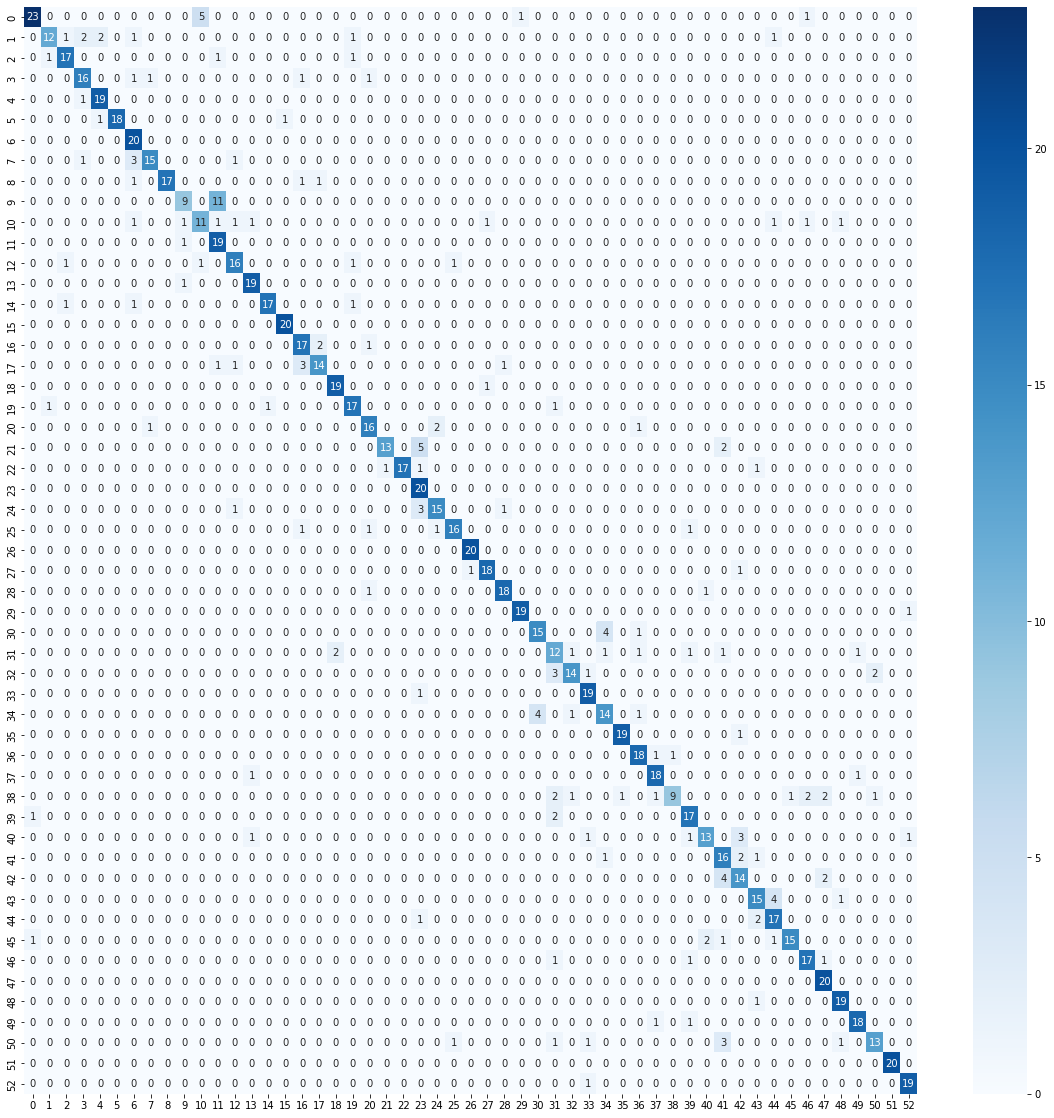

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


conftest =  confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(conftest)

plt.figure(figsize = (20,20))
sns.heatmap(conftest, cmap = 'Blues' ,annot=True, fmt='d')


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv1D, Dropout
from tensorflow.keras.layers import AveragePooling1D, UpSampling1D, Activation
from tensorflow.keras.layers import ZeroPadding1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM


class CNN_LSTM():

  def __init__():
    self.num_classes = 53


  def model(self): 

    inputs = Input(shape=(48, 1))
    x = Conv1D(32, 7, padding='same', strides=1)(inputs)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = BatchNormalization(axis=-1, momentum=0.99)(x)
    x = Dropout(0.5)(x)
    x = Conv1D(32, 7, padding='same', strides=1)(x)
    x = Activation('relu', name='encoder_out')(x)
    x = LSTM(256)(x)
    x = Flatten()(x)
    clf_x = Dense(self.num_classes, activation='softmax')(x)

    clf = tf.keras.models.Model(inputs=inputs,
                                outputs=clf_x)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    clf.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])
    
    return clf
clf.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=300, batch_size=64)


Epoch 1/300
34/34 [==============================] - 6s 105ms/step - loss: 3.8473 - accuracy: 0.0330 - val_loss: 4.2193 - val_accuracy: 0.0280
Epoch 2/300
34/34 [==============================] - 3s 86ms/step - loss: 3.6007 - accuracy: 0.0788 - val_loss: 3.7953 - val_accuracy: 0.0551
Epoch 3/300
34/34 [==============================] - 4s 112ms/step - loss: 3.3604 - accuracy: 0.1080 - val_loss: 3.3635 - val_accuracy: 0.1112
Epoch 4/300
34/34 [==============================] - 3s 85ms/step - loss: 3.1014 - accuracy: 0.1538 - val_loss: 3.0486 - val_accuracy: 0.1664
Epoch 5/300
34/34 [==============================] - 3s 85ms/step - loss: 2.9413 - accuracy: 0.1788 - val_loss: 2.7755 - val_accuracy: 0.2103
Epoch 6/300
34/34 [==============================] - 3s 90ms/step - loss: 2.8006 - accuracy: 0.2175 - val_loss: 2.5748 - val_accuracy: 0.2682
Epoch 7/300
34/34 [==============================] - 3s 82ms/step - loss: 2.6628 - accuracy: 0.2363 - val_loss: 2.3767 - val_accuracy: 0.3047
Epoc

In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79        30
           1       0.56      0.70      0.62        20
           2       0.88      0.70      0.78        20
           3       0.68      0.85      0.76        20
           4       1.00      0.90      0.95        20
           5       1.00      1.00      1.00        20
           6       0.84      0.80      0.82        20
           7       0.75      0.75      0.75        20
           8       0.90      0.95      0.93        20
           9       0.70      0.70      0.70        20
          10       0.81      0.65      0.72        20
          11       0.71      0.75      0.73        20
          12       0.84      0.80      0.82        20
          13       0.90      0.90      0.90        20
          14       0.90      0.95      0.93        20
          15       0.95      1.00      0.98        20
          16       1.00      0.85      0.92        20
          17       0.84    

[[24  0  0 ...  0  0  0]
 [ 0 14  2 ...  0  0  0]
 [ 1  3 14 ...  0  0  0]
 ...
 [ 0  1  0 ... 15  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0 18]]


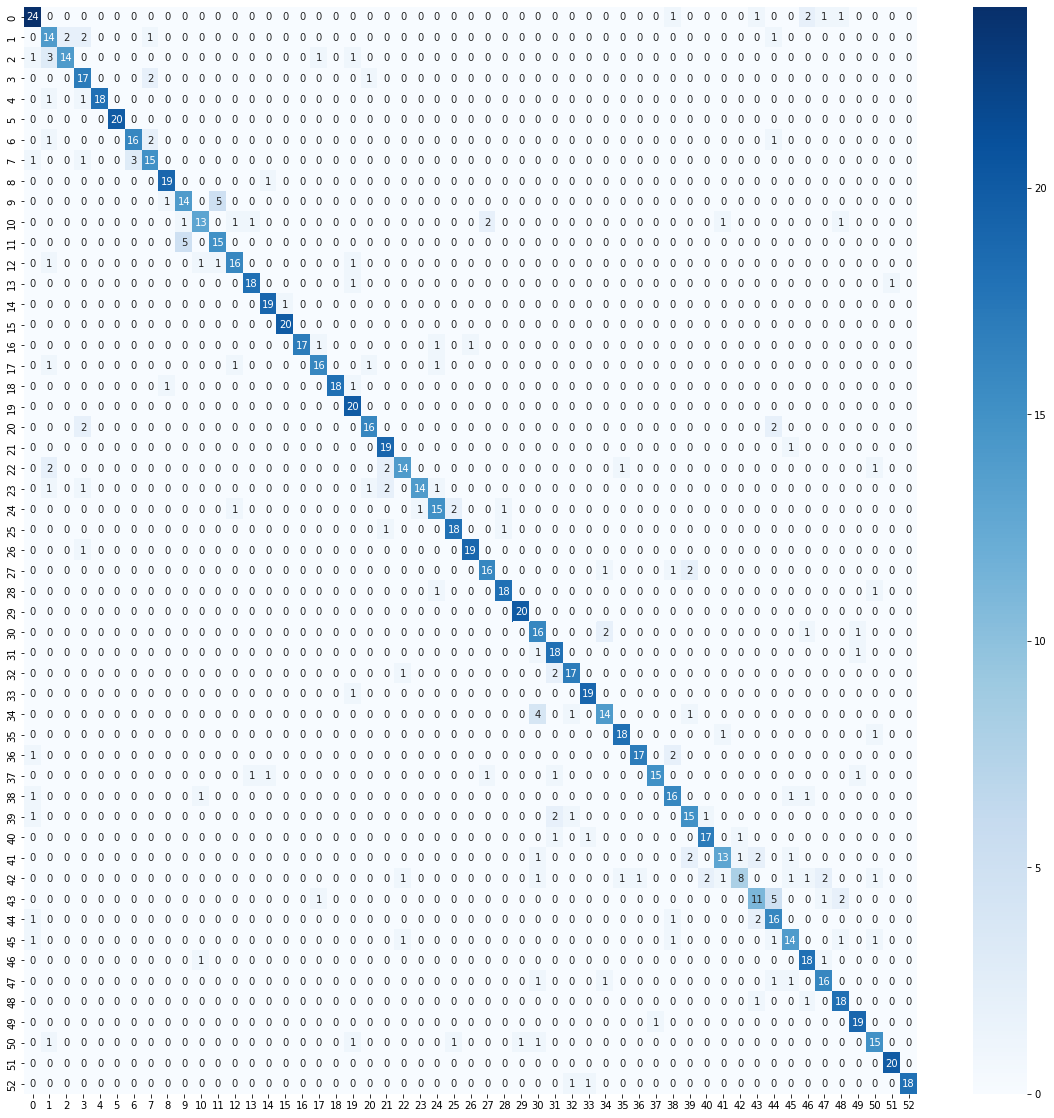

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


conftest =  confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(conftest)

plt.figure(figsize = (20,20))
sns.heatmap(conftest, cmap = 'Blues' ,annot=True, fmt='d')


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv1D, Dropout
from tensorflow.keras.layers import AveragePooling1D, UpSampling1D, Activation
from tensorflow.keras.layers import ZeroPadding1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM

class LSTM():
  def __init__():
    self.num_classes = 53

  def model(self)
    inputs = Input(shape=(48, 1))
    x = LSTM(512)(inputs)
    x = Dense(256)(x)
    x = Dense(128)(x)
    clf_x = Dense(self.num_classes, activation='softmax')(x)

    clf = tf.keras.models.Model(inputs=inputs,
                                outputs=clf_x)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    clf.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])
    
   return clf
clf.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=300, batch_size=64)


Epoch 1/300
34/34 [==============================] - 27s 728ms/step - loss: 3.9954 - accuracy: 0.0316 - val_loss: 3.8432 - val_accuracy: 0.0533
Epoch 2/300
34/34 [==============================] - 24s 717ms/step - loss: 3.7582 - accuracy: 0.0599 - val_loss: 3.7084 - val_accuracy: 0.0710
Epoch 3/300
34/34 [==============================] - 24s 708ms/step - loss: 3.6607 - accuracy: 0.0651 - val_loss: 3.5773 - val_accuracy: 0.0822
Epoch 4/300
34/34 [==============================] - 24s 716ms/step - loss: 3.6054 - accuracy: 0.0722 - val_loss: 3.5910 - val_accuracy: 0.0636
Epoch 5/300
34/34 [==============================] - 27s 806ms/step - loss: 3.6005 - accuracy: 0.0731 - val_loss: 3.5705 - val_accuracy: 0.0813
Epoch 6/300
34/34 [==============================] - 26s 756ms/step - loss: 3.5626 - accuracy: 0.0825 - val_loss: 3.5661 - val_accuracy: 0.0897
Epoch 7/300
34/34 [==============================] - 26s 756ms/step - loss: 3.5679 - accuracy: 0.0759 - val_loss: 3.5599 - val_accuracy:

In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83        30
           1       0.42      0.40      0.41        20
           2       0.64      0.35      0.45        20
           3       0.50      0.05      0.09        20
           4       0.48      0.50      0.49        20
           5       0.78      0.35      0.48        20
           6       0.40      0.40      0.40        20
           7       0.27      0.35      0.30        20
           8       0.38      0.40      0.39        20
           9       0.29      0.50      0.36        20
          10       0.33      0.20      0.25        20
          11       0.36      0.20      0.26        20
          12       0.43      0.30      0.35        20
          13       0.46      0.65      0.54        20
          14       0.25      0.15      0.19        20
          15       0.50      0.15      0.23        20
          16       0.44      0.35      0.39        20
          17       0.22    

[[22  3  0 ...  0  0  0]
 [ 0  8  1 ...  0  0  1]
 [ 0  2  7 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  2  1]
 [ 0  0  0 ...  0 12  7]
 [ 0  0  0 ...  0  3 10]]


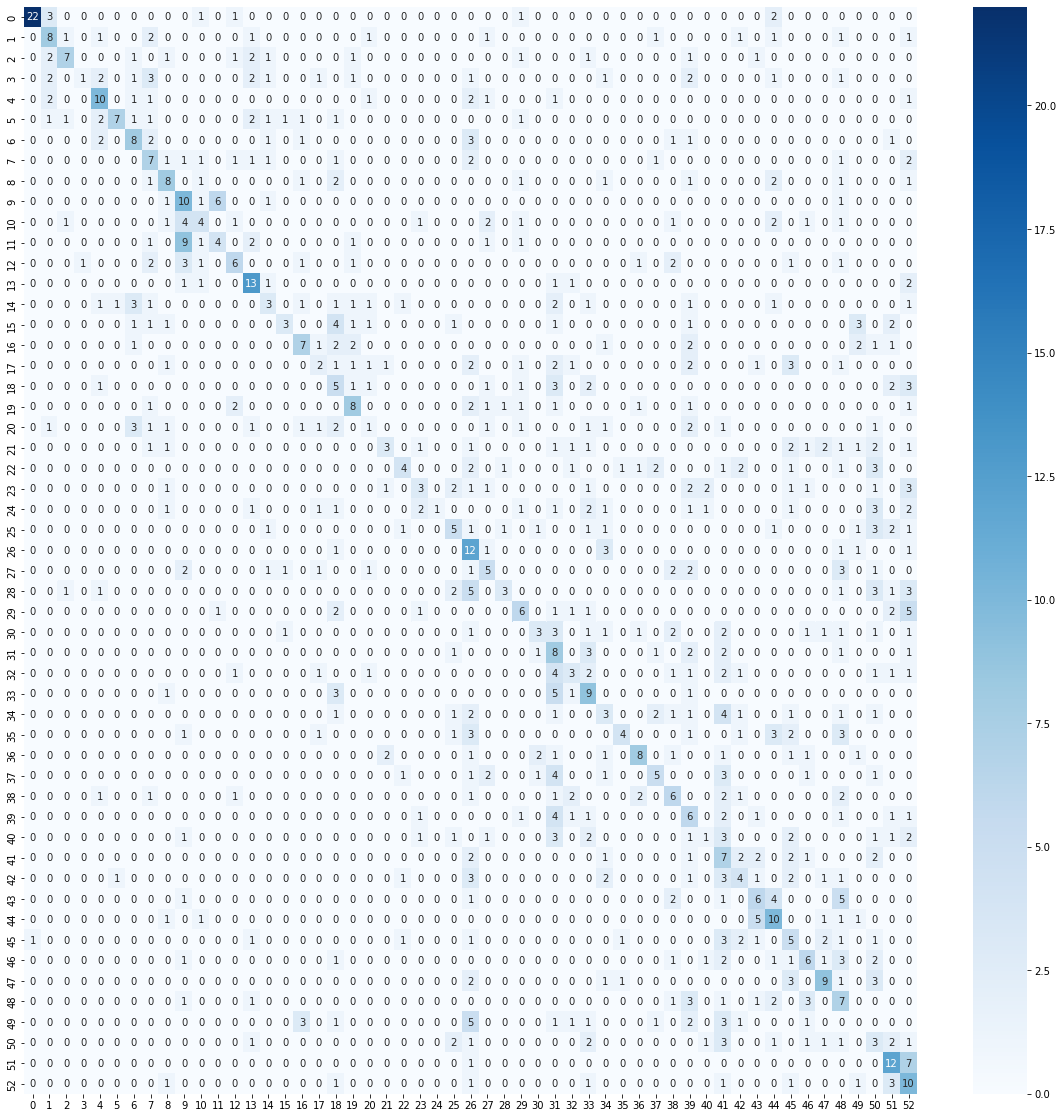

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


conftest =  confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(conftest)

plt.figure(figsize = (20,20))
sns.heatmap(conftest, cmap = 'Blues' ,annot=True, fmt='d')
